# **Imported Libraries**

In [ ]:
import io
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# **Data Loading**

In [ ]:
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [ ]:
data = pd.read_csv(io.StringIO(uploaded['healthcare-dataset-stroke-data.csv'].decode('utf-8')))

In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Data Visualization**

In [ ]:
vData=data.copy()

### **1. Descriptive Analytics**

In [ ]:
vData.drop(columns=['id'],inplace=True) 
vData.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Observations :

1) BMI contains missing values.

2) The average age is 43.

3) The average bmi is 28 (will change after imputation).

4) The minimum age is questionable.

5) Average glucose level is 106 

* Getting the missing values in the data:

In [ ]:
def draw_missing_data_table(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
draw_missing_data_table(vData)

,Total,Percent
bmi,201,0.039335
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
smoking_status,0,0.000000


### **2. Visualizations**

* The Stroke Percentage

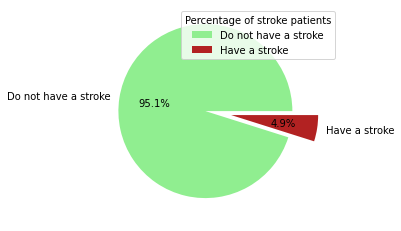

In [ ]:
dt_target_recoured=vData['stroke'].astype('int32')
dt_target_recoured.value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(dt_target_recoured.value_counts() , labels = ['Do not have a stroke' , 'Have a stroke'] , autopct='%1.1f%%', 
        colors=['lightgreen','firebrick'] , explode=(0.3,0) )

plt.legend(title = "Percentage of stroke patients" )
plt.show() 

* Missing Values

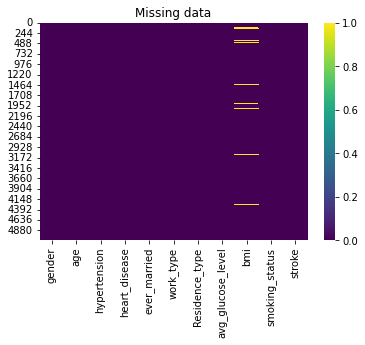

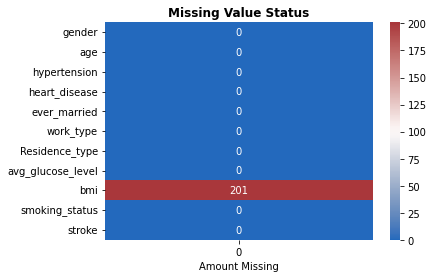

In [ ]:
vData.isnull().sum()
sns.heatmap(vData.isnull(),cmap='viridis')
plt.title('Missing data')
plt.show()

print('   ')

plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(vData.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

* Distribution Of Data 

In [ ]:
for i in vData.drop(["stroke"], axis=1).columns:
    fig = px.histogram(vData, x=i, color='stroke')
    fig.show()

* Features Realtionship

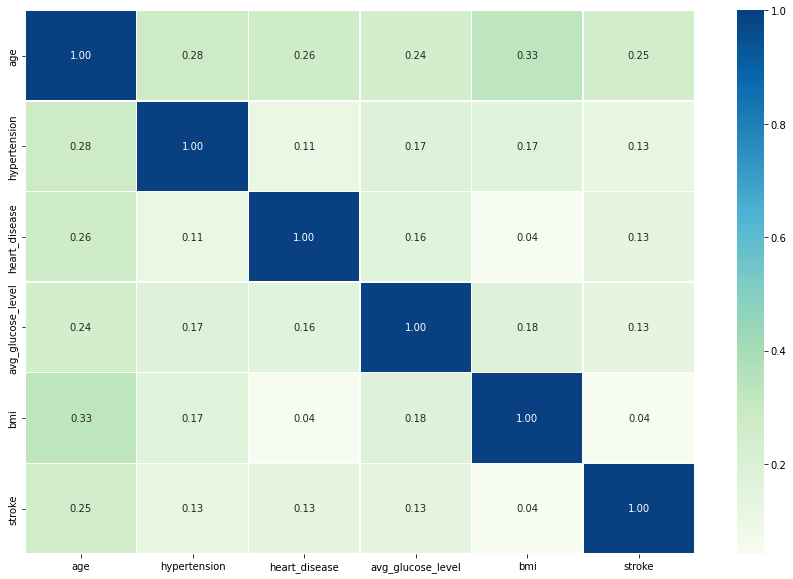

In [ ]:
corr_matrix = vData.corr()
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(
    corr_matrix, 
    annot = True, 
    linewidths = 0.5,
    fmt = '0.2f', 
    cmap = 'GnBu'
)

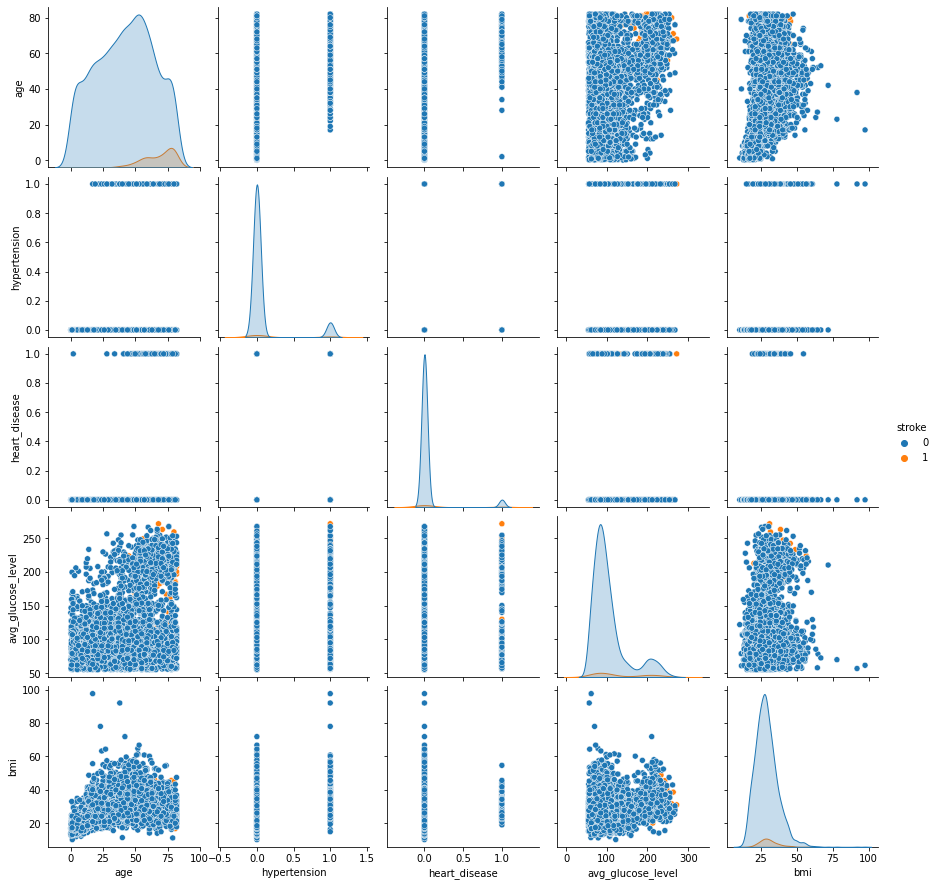

In [ ]:
sns.pairplot(data=vData,hue="stroke")

* Insights:

-There are few cases of strokes in children.

-Both Urban and rural have equal number of stroke cases, so this is not a useful feature.

-Age has the highest correlation with all the features.

-As peopke start to age the risk of having a stroke increases as most of the stroke cases belong to 60-80 age group.

-Patients with stroke have avg_glucose_level higher than 120.

-Normaly people who smoke are more likely of having a chance of stroke but in our dataset smoking doesn't have much impact.

-Women in their early 30s have a higher risk for stroke compared to men. The risk for stroke for men starts from age 45.

-Hypertension and heart disease increase the risk of an individual having a stroke. However, there were more stroke cases with hypertension than with heart disease.

-Living conditions or work history does not affect the risk for stroke.

-Married people have higher risk of stroke than the unmarried ones.

-The dataset is imbalanced.

# **Data Preprocessing**

In [ ]:
# identify categorical and continous columns
categorical_cols = ['gender','hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
cont_cols = ["age","avg_glucose_level","bmi"]
target_col = ["stroke"]

### **1. Handling Missing Values**
 

- Imputing the missing value with the mode

In [ ]:
data['bmi'] = data['bmi'].fillna(data['bmi'].mode()[0])

In [ ]:
print("Any Missing Values:", data.isnull().values.any())

Any Missing Values: False


### **2. Data Transformation**
* Remove Outliers from avg_glucose_level

In [ ]:
data.drop(data[(data['avg_glucose_level'] > data['avg_glucose_level'].quantile(0.975)) | (data['avg_glucose_level'] < data['avg_glucose_level'].quantile(0.025))].index,inplace=True)

### **3. Miscellaneous**

* Removing Gender of type 'Other'

In [ ]:

indices = data[data['gender']=='Other'].index
for i in indices:
  data.drop(i, axis=0, inplace=True)

* Drop Id Column

In [ ]:
data.drop('id',axis=1,inplace=True)

* Dealing with 'unknown' smoking-status

In [ ]:
data[(data['smoking_status'] == 'Unknown') & (data['age'] < 20) & (data['work_type'] == 'children')] = data[(data['smoking_status'] == 'Unknown') & (data['age'] < 20) & (data['work_type'] == 'children')].replace('Unknown','never smoked')
data['smoking_status'] = data['smoking_status'].replace('Unknown', 'smokes')


In [ ]:
pd.crosstab(data.smoking_status, data.stroke,
           rownames=['smoking_status'], colnames=['stroke'])

stroke,0,1
smoking_status,,
formerly smoked,766,63
never smoked,2308,82
smokes,1552,83


**4. Binning the Continuous Features**
* Categorize into age groups

In [ ]:
bins = [0,15,25,45,65,90]
labels = ['0-15','15-25','25-45','45-65','65-90']
data['age'] = pd.cut(data['age'], bins=bins, labels=labels)
data.age = data.age.replace({'0-15':0,'15-25':1, '25-45':2, '45-65':3, '65-90':4})

* Categorize BMI value

In [ ]:
bins = [-np.inf,18.5, 25, 30, 40, np.inf]
labels = ['underweight','healthy','overweight','obese1','obese2']
data['bmi'] = pd.cut(data['bmi'], bins=bins, labels=labels)
data.bmi = data.bmi.replace({'underweight':0,'healthy':1, 'overweight':2, 'obese1':3, 'obese2':4})

* Categorize Average Glucose Level

In [ ]:
bins = [0,90,160,230,500]
labels = ['Low', 'Normal', 'High', 'Very High']
data['avg_glucose_level'] = pd.cut(data['avg_glucose_level'], bins=bins, labels=labels)
data.avg_glucose_level = data.avg_glucose_level.replace({'Low':0, 'Normal':1, 'High':2, 'Very High':3})

### **5. Feature Encoding**

In [ ]:
def CatOne_transform(df,feature):
  trans = OneHotEncoder()
  X_cat = trans.fit_transform(df[feature])
  feature_name = trans.get_feature_names_out()
  return feature_name,X_cat

input_features = categorical_cols
features, MaleFemale = CatOne_transform(data, input_features)

In [ ]:
test_data = data.copy()
test_data.drop(input_features,axis=1,inplace=True)
test_features = test_data.columns
X = np.concatenate((MaleFemale.toarray(),test_data.to_numpy()),axis=1)

In [ ]:
X = pd.DataFrame(X, columns=features.tolist() + test_features.to_list())
X.drop(target_col,axis=1,inplace=True)
y = data["stroke"]

### **6. Handling Imbalanced Data**

In [ ]:
print('Before OverSampling, counts of label 1: {}'.format(sum(data["stroke"]==1)))
print('Before OverSampling, counts of label 0: {} \n'.format(sum(data["stroke"]==0)))

Before OverSampling, counts of label 1: 228
Before OverSampling, counts of label 0: 4626 



In [ ]:
su = SMOTE(random_state=42)
X, y = su.fit_resample(X, y)

In [ ]:
print('After OverSampling, counts of label 1: {}'.format(sum(y == 1)))
print('After OverSampling, counts of label 0: {}'.format(sum(y == 0)))

After OverSampling, counts of label 1: 4626
After OverSampling, counts of label 0: 4626


### **7. Data Splitting**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

# **Modeling**

In [ ]:
models = []
models.append(['Logistic Regression',LogisticRegression(random_state=0, max_iter=200), {'C':[i for i in range(1, 25)]}])
models.append(['SVM',SVC(random_state=0), {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[i for i in range(1, 10)]}])
models.append(['KNeigbors',KNeighborsClassifier(), {'n_neighbors': [i for i in range(1, 15)]}] )
models.append(['GaussianNB',GaussianNB()] )
models.append(['DecisionTree',DecisionTreeClassifier(random_state=0), {'criterion': ('gini', 'entropy')}])
models.append(['Random Forest',RandomForestClassifier(random_state=0), {'n_estimators': [i for i in range(100, 500, 100)], 'criterion': ['gini', 'entropy']}])

In [ ]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    best_param = None
    print(models[m][0],': \n')

    if models[m][0]!='GaussianNB':
      gridSearchClf = GridSearchCV(estimator=models[m][1], param_grid=models[m][2], cv= 5)
      gridSearchClf.fit(x_train,y_train)
      best_param = gridSearchClf.best_params_
      print(f'best estimators: {best_param} \n')

    if models[m][0]=='SVM':
      models[m][1] = SVC(random_state=0, C=best_param['C'], kernel=best_param['kernel'])

    if models[m][0]=='KNeigbors':
      models[m][1] = KNeighborsClassifier(n_neighbors=best_param['n_neighbors'])
    
    if models[m][0]=='DecisionTree':
      models[m][1] = DecisionTreeClassifier(criterion=best_param['criterion'], random_state=0)
    
    if models[m][0]=='Logistic Regression':
      models[m][1] = LogisticRegression(C=best_param['C'], random_state=0, max_iter=200)

    if models[m][0]=='Random Forest':
      models[m][1] = RandomForestClassifier(n_estimators=best_param['n_estimators'], criterion=best_param['criterion'], random_state=0)

    model = models[m][1]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracies = cross_val_score(estimator= model, X = x_train,y = y_train, cv=10)

    # k-fOLD Validation
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    print(f"Confusion Matrix :- \n {cm} \n")
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)} \n')
    print(f'K-Fold Validation Mean Accuracy: {accuracies.mean()*100} % \n')
    print(f'Standard Deviation: {accuracies.std()*100} % \n')
    print(f'ROC AUC Score: {roc} % \n')
    print(f"Classiication Report : -\n {classification_report(y_test, y_pred)}")
    print('-'*40)
    print('')
    lst_2.append(models[m][0])
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

Logistic Regression : 

best estimators: {'C': 4} 

Confusion Matrix :- 
 [[688 239]
 [154 770]] 

Accuracy Score: 0.7876823338735819 

K-Fold Validation Mean Accuracy: 78.78644636539373 % 

Standard Deviation: 1.0241510425067597 % 

ROC AUC Score: 0.7877562028047466 % 

Classiication Report : -
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       927
           1       0.76      0.83      0.80       924

    accuracy                           0.79      1851
   macro avg       0.79      0.79      0.79      1851
weighted avg       0.79      0.79      0.79      1851

----------------------------------------

SVM : 

best estimators: {'C': 9, 'kernel': 'rbf'} 

Confusion Matrix :- 
 [[734 193]
 [ 38 886]] 

Accuracy Score: 0.8752025931928687 

K-Fold Validation Mean Accuracy: 88.09610825400298 % 

Standard Deviation: 0.8086161761551734 % 

ROC AUC Score: 0.8753379845612855 % 

Classiication Report : -
               precision    recall 